<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/04 - Unsupervised Learning/palladium_dimers_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating palladium catalyst discovery: a practical application of unsupervised learning

## Table of content

1. Problem introduction
2. General clustering
3. DFT-specific descriptors
4. Final Clustering
5. Experimental validation

In this tutorial we will see how a simple algorithm like k-means can be used to discover new catalysts using few experimental data to guide the next experiments. We will see how a clever use of ML-techniques is able to reveal unintuitive patterns and suggest tests that would be otherwise ignored.

The notebook is based on the work of Hueffel et al. and was published in this [Science](https://www.science.org/doi/full/10.1126/science.abj0999) article in 2021.

# 0. Relevant packages

### Usual stuff

# 1. - Problem introduction

- Speciation of metal catalysts
- PCA + DFT efforts failed
- Why Pd(I) is interesting

As usual, we will download the necessary libraries and data before starting the work.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
## Download data
ligands = pd.read_csv('data/LKB_P.csv', sep=';')

ligands.head()

,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(B),BE(B),P-B,DP-A(B),...,BE(Pt),P-Pt,DP-A(Pt),DA-P-A(Pt),<(H3P)Pt(PH3),S4',PC1,PC2,PC3,PC4
0,1,R,-0.24636,-0.00029,2.30,190.60,-0.590,26.10,1.941,-0.013,...,8.80,2.328,-0.001,1.5,109.4,66.9,-3.078,0.798,6.079,-1.066
1,2,R,-0.19045,0.03268,3.00,233.00,-0.680,39.20,1.926,-0.028,...,12.90,2.331,-0.010,1.3,107.5,39.4,1.602,3.976,1.536,0.090
2,3,R,-0.27742,-0.05837,3.00,182.30,-0.560,26.30,1.915,-0.002,...,22.80,2.250,0.008,-0.1,109.0,52.2,-7.226,-3.302,2.929,2.032
3,4,R,-0.26620,-0.11270,20.66,194.04,-0.538,22.51,1.924,-0.005,...,16.58,2.260,0.046,-2.4,106.6,28.7,-6.715,-9.291,1.348,-0.823
4,5,R,-0.18723,0.02584,6.00,239.10,-0.680,39.00,1.934,-0.027,...,17.10,2.338,-0.010,1.6,107.4,39.0,2.280,3.408,1.584,0.168


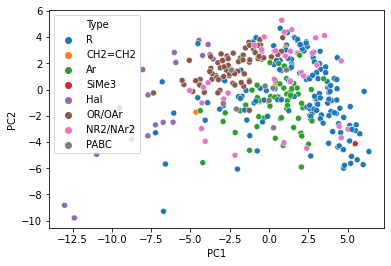

In [5]:
import seaborn as sns

sns.scatterplot(data=ligands, x='PC1', y='PC2', hue='Type');

You can clearly see how we are not able to cluster using PCA

### 1.- General property clustering

First step, we will see if k-means algorithm is able to cluster our ligands efficiently. This will allow to reduce the number of possible molecules we have to consider.

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
# Load data and standardize it
process = ['E(HOMO)', 'E(LUMO)', 'He8_steric', 'PA', 'Q(B)', 'BE(B)', 'P-B', 'DP-A(B)', 'DA-P-A(B)', 'Q(Au)', 'BE(Au)',
           'Au-Cl', 'Au-P', 'DP-A(Au)', 'DA-P-A(Au)', 'Q(Pd)', 'BE(Pd)', 'Pd-Cl trans', 'P-Pd', 'DP-A(Pd)',
           'DA-P-A(Pd)', 'Q(Pt)', 'BE(Pt)', 'P-Pt', 'DP-A(Pt)', 'DA-P-A(Pt)', '<(H3P)Pt(PH3)', "S4'"]
# Columns in the data set to exclude from clustering
drop = ['Type', "PC1", "PC2", "PC3", "PC4"]

# IDs of reference ligands
pos_refs = [16, 41, 54, 113]
neg_refs = [21]


# Data processing
ligands = ligands.drop(columns=drop)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(ligands), columns=ligands.columns, index=ligands.index)
X.head()

,No.,E(HOMO),E(LUMO),He8_steric,PA,Q(B),BE(B),P-B,DP-A(B),DA-P-A(B),...,P-Pd,DP-A(Pd),DA-P-A(Pd),Q(Pt),BE(Pt),P-Pt,DP-A(Pt),DA-P-A(Pt),<(H3P)Pt(PH3),S4'
0,-1.727081,-2.232740,0.980551,-0.912518,-2.346474,1.740989,-2.136985,0.535505,0.887864,2.702930,...,-0.987329,-0.236676,2.696475,-0.363555,-1.066056,0.007705,-0.552862,1.199453,1.262842,2.241859
1,-1.717126,0.049098,1.881761,-0.843231,-0.032599,-0.439163,1.031359,-0.095354,-0.481713,1.272138,...,-0.417212,-1.234552,1.536916,-1.069599,-0.298420,0.080835,-1.286575,1.064062,0.124321,0.170313
2,-1.707172,-3.500382,-0.607022,-0.843231,-2.799425,2.467707,-2.088613,-0.557984,1.892220,0.262167,...,-0.987329,2.142876,-0.608269,1.904799,1.555142,-1.893666,0.180851,0.116327,1.023153,1.134523
3,-1.697218,-3.042464,-2.092091,0.904776,-2.158744,3.000633,-3.005257,-0.179468,1.618304,-0.831969,...,0.770532,3.831590,-1.361982,3.887732,0.390581,-1.649900,3.278753,-1.440666,-0.414978,-0.635707
4,-1.687263,0.180515,1.694795,-0.546288,0.300293,-0.439163,0.982987,0.241104,-0.390408,1.440467,...,0.081640,-0.620474,1.015114,-1.129688,0.487940,0.251471,-1.286575,1.267148,0.064399,0.140181


In [17]:
## Do k-means clustering 
inert = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=1)
    kmeans.fit(X)

    clust = pd.DataFrame({"Cluster": kmeans.labels_}, index=X.index)
    inert.append(kmeans.inertia_)

In [9]:
clust

,Cluster
0,2
1,3
2,2
3,4
4,3
...,...
343,1
344,5
345,5
346,5


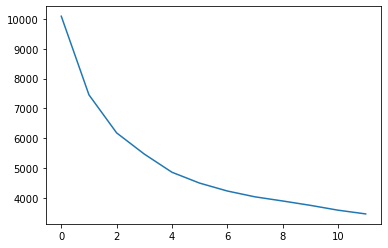

In [18]:
plt.plot(inert)

### 2.- DFT-specific descriptors

The first clustering reduced the candidate ligands space to ~25% of the original size, keeping 66 ligands from the list of 348. A subsequent k-means clustering using the general descriptors in order to refine this first filtering failed. Therefore, the descriptors needed to be refined for this specific problem. DFT-specific descriptors related to the Pd(I) iodine bridge were introduced (up to )

In [3]:
#Load DFT descriptors
dimers = pd.read_csv('data/Dimer_LKB_P.csv', sep=';')

dimers.head()


,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(Pd),BE(Pd),Pd-Cl trans,P-Pd,...,G_NBO_Pd,G_NBO_P,G_LENGTH_Pd_P,G_LENGTH_Pd_Pd,G_TORSION_Pd_I_I_Pd,G_ORDER_Pd_Pd,PC1',PC2',PC3',PC4'
0,15,R,-0.17500,0.02350,37.82,247.52,-1.257,30.03,2.379,2.337,...,-0.379685,1.297005,2.312152,3.226557,103.059842,0.1171,-0.986788,0.414056,0.017615,-0.632639
1,16,R,-0.17267,0.02754,23.38,250.80,-1.200,23.90,2.382,2.418,...,-0.278010,1.232615,2.413734,4.305073,174.451579,0.0264,1.198717,1.162347,0.901051,-0.055612
2,19,R,-0.18340,0.01900,31.31,243.63,-1.282,28.25,2.377,2.308,...,-0.340260,1.205245,2.314010,3.620629,124.149654,0.0713,-0.146169,-0.318877,0.877642,-0.227544
3,36,R,-0.17840,0.02300,19.69,245.86,-1.275,34.79,2.379,2.321,...,-0.365385,1.280040,2.317294,3.187955,101.341176,0.1254,-1.135555,0.275201,0.181931,-0.516078
4,37,R,-0.17790,0.02220,18.53,246.58,-1.253,35.72,2.380,2.334,...,-0.387150,1.284050,2.346424,3.102411,95.391197,0.1369,-0.904739,0.447820,0.106396,-0.301205


In [4]:
dimers.columns

Index(['No.', 'Type', 'E(HOMO)', 'E(LUMO)', 'He8_steric', 'PA', 'Q(Pd)',
       'BE(Pd)', 'Pd-Cl trans', 'P-Pd', 'DP-A(Pd)', 'DA-P-A(Pd)', 'PC1', 'PC2',
       'PC3', 'PC4', 'BDE1', 'BDE2', 'BDE3', 'COMP1', 'DIM1', 'REORG1',
       'REDOX1', 'REDOX2', 'REDOX3', 'REDOX4', 'A_NBO_P', 'B_NBO_Pd',
       'B_NBO_P', 'B_LENGTH_Pd_P', 'B_B1', 'B_lval', 'B_newB5', 'C_NBO_Pd',
       'C_NBO_P', 'C_LENGTH_Pd_P', 'C_ANGLE_P_Pd_P', 'D_NBO_Pd', 'D_NBO_P',
       'D_LENGTH_Pd_P', 'D_LENGTH_Pd_Pd', 'D_ANGLE_P_Pd_P', 'D_ORDER_Pd_Pd',
       'E_NBO_Pd', 'E_NBO_P', 'E_LENGTH_Pd_P', 'E_ANGLE_I_Pd_I', 'F_NBO_Pd',
       'F_NBO_P', 'F_LENGTH_Pd_P', 'F_ANGLE_P_Pd_P', 'F_ANGLE_I_Pd_I',
       'G_NBO_Pd', 'G_NBO_P', 'G_LENGTH_Pd_P', 'G_LENGTH_Pd_Pd',
       'G_TORSION_Pd_I_I_Pd', 'G_ORDER_Pd_Pd', 'PC1'', 'PC2'', 'PC3'', 'PC4''],
      dtype='object')

In [5]:
len(dimers)

66

### 3.- Final clustering: unraveling new ligands

Once the new descriptors were calculated, a second k-means clustering was used

### 4.- Experimental validation

### Conclusion

Link to the repo.